## Lab 2: Introduction to Supervised Learning

### Overview
This lab will provide a brief introduction to *supervised* learning through two example problems: *classification* and *regression*. For this, we will employ two similair models: logistic regression and linear regression, respectively. Although this can be implemented effectively using pre-built functions from **scipy**: [logistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.logistic.html) & [linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html), we will code them from scratch by implementing gradient descent with **numpy**.

#### I. Data Processing - MNIST Dataset

#### II. Logistic Regression (2 classes of MNIST digits)
- Sigmoid
- Negative Log Likelihood
- Using Gradient Descent to solve Logistic Regression

#### III. Linear Regression (USA housing data)
- Mean Squared Error
- Using Gradient Descent to solve Linear Regression
- Closed form solution of Linear Regression

### Assignment 
You are required to provide the code for *four* questions throughout the notebook:
- **Question 1**: Implementing Logistic Regression - Gradient Descent
- **Question 2**: Data Processing - Housing
- **Question 3**: Implementing Linear Regression - Derivation + Loss + Gradient Descent  



In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
# colors used
ORANGE = '#FF9132'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
FIG_WIDTH = 4
FIG_HEIGHT = 3

plt.rcParams.update({
    "text.usetex": False,
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 2
})


## I. Data Processing - MNIST Dataset
We will briefly go over *some* common steps of data processing in machine learning, where the example we will use is the MNIST dataset. Generally speaking, these steps often involve loading, cleaning, normalizing, and splitting the data into two parts, used for training and testing our learned model. This last step is crucial, as we want our learned model to *generalize* to unseen data, instead of *overfitting* on the provided dataset. [Chapter 5](https://www.deeplearningbook.org/contents/ml.html) of the Deep Learning Book gives a good summary of this paradigm and its relationship to the bias-variance trade-off commonly considered when building Machine Learning models. However, we will not discuss such details in this introductary lab.

[MNIST](http://yann.lecun.com/exdb/mnist/) is a well known dataset of handwritten digits containing 60,000 training images and 10,000 testing images. The dataset comes labeled, with a total of 10 classes (one for each digit.) For our task, I have conveniently provided a subset of the data corresponding to the digits 6 and 9. My intuition is that these two digits should be easy to distinguish between..., can you guess why?

We can load the data from a csv file using the popular [pandas](https://pandas.pydata.org/) library. The first column is used to denote the label, 0 or 1 for 6 or 9 respectively. The remaining 784 columns denote a floating point value representing the grayscale pixel value of the image. Since there are 28*28 pixels per image in the original dataset, these values represent the flattened (row by row) image.  

In [2]:
cwd = os.getcwd()
# display your current working directory
print(cwd)
# read in the mnist dataset
mnist_path = cwd + '/data/mnist.csv'
df = pd.read_csv(mnist_path, header=None)
print(df[0].value_counts())
df.head()

/home/mark/Documents/code/ml_tutorial/content/lab2
0
0.0    2505
1.0    2495
Name: count, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1.0,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,...,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213
1,0.0,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,...,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213
2,0.0,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,...,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213
3,0.0,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,...,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213
4,1.0,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,...,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213,-0.424213


A quick observation shows us that the dataset contains 5000 digits, with 2505 being 6, and 2495 being 9. 

We visualize some of the samples below:

In [3]:
def imshow_mnist(img, labels):
    # -1 is used to imply a dimension 
    img = img.reshape(-1,28)
    plt.imshow(img, cmap='gray')
    ticks = np.arange(14,img.shape[0],28)
    plt.yticks(ticks=ticks ,labels=labels)
    plt.xticks([])
    plt.show()

[Lambda expressions](https://docs.python.org/3/tutorial/controlflow.html) can be useful in python when we want to define small expressions. 

In [4]:
get_label = lambda x : 6 + 3*x
print(get_label(np.array([0,1,1])))

[6 9 9]


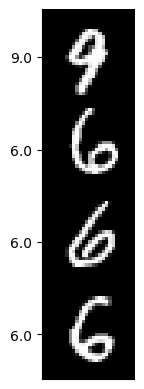

In [5]:
# split the first 4 rows into image (x) and label (y)
x, y = df[0:4].to_numpy()[:,1:], df[0:4].to_numpy()[:,0] 
imshow_mnist(x,get_label(y))

We would like to split the dataset into two parts, keeping 20% of the data for testing our model. Since we want the distribution of both datasets to be the same (ratio of labels), we need to do this with care. While randomly sampling on such a large dataset will suffice, we can use pandas built in methods to make our job easier. Furhtermore, we load the stratified dataset into a python dictionary for later use. 

In [6]:
# stratify
def train_test_split(df, test_size=0.2):
    shuffled_df = df.sample(frac=1).reset_index(drop=True)
    test_index = int(len(df) * test_size)
    test_df = shuffled_df[:test_index]
    train_df = shuffled_df[test_index:]
    return train_df, test_df

# split into train and test, keeping data in pandas format
train_df, test_df = train_test_split(df, test_size=0.2)

# load into dicionary converting to numpy arrays
data = {}
data["x_train"] = train_df.to_numpy()[:,1:]
data["x_test"] = test_df.to_numpy()[:,1:]
data["y_train"] = train_df.to_numpy()[:,0]
data["y_test"] = test_df.to_numpy()[:,0]

print("Dictionary contains the following: \n")
for key, value in data.items():
    print(f"{key}:\n\t{type(value)}\n\t{value.shape}")


Dictionary contains the following: 

x_train:
	<class 'numpy.ndarray'>
	(4000, 784)
x_test:
	<class 'numpy.ndarray'>
	(1000, 784)
y_train:
	<class 'numpy.ndarray'>
	(4000,)
y_test:
	<class 'numpy.ndarray'>
	(1000,)


## II. Logistic Regression - Binary Classification of MNIST digits

Logistic Regression is a classification algorithm used to differentiate data into discrete classes. The simplest form of this algorithm is the binary setting, where we have only two classes, $0$ and $1$. 

Given a dataset $\mathcal{X}=\{x_1,x_2,\ldots,x_N\}$ of $d$-dimensional vectors $x$, we have a corresponding set of labels $\mathcal{Y}=\{y_1,y_2,\ldots,y_N\}$ where  $y_i\in\{0,1\}$. Our job is to build a classifier $h_{\theta}$ that can calculate the probability a given $x$  belongs to class $1$, sometimes thought of as "success". We can think of this probability as a score, where our classifier outputs an estimate $0\leq h_{\theta}(x)\leq1$. So what is $\theta$ and what kind of function is our classifier $h_{\theta}$?

$$h_{\theta}=\sigma(\theta^\intercal x).$$

We can see that $\theta$ is a $d$-dimensional vector that maps our input vector $x$ to a real number. This is done in linear regression to map our data to a continous value, but since we want a probability of belonging to a given class we can not stop here. This is where the sigmoid function comes in, we use it to map this value between zero and one. 
$$\sigma(x)=\frac{1}{1+e^{-x}}$$

Why would such a function be used here, let's take a look at it. 

In [7]:
def _positive_sigmoid(x):
    "standard sigmoid equation"
    return 1 / (1 + np.exp(-x))


def _negative_sigmoid(x):
    "equiv to standard equation, but multiply num and denom by e^x"
    # Cache exp so you won't have to calculate it twice
    exp = np.exp(x)
    return exp / (exp + 1)


def sigmoid(x):
    "numerically stable sigmoid to avoid exponential overflow"
    positive = x >= 0
    # Boolean array inversion
    negative = ~positive

    result = np.empty_like(x, dtype=np.float64)
    result[positive] = _positive_sigmoid(x[positive])
    result[negative] = _negative_sigmoid(x[negative])

    return result

Play around with the x_min, x_max values below and see what it looks like.


We can see that it is quite sensative to the range, with its behaviour going from a step function to a line. 

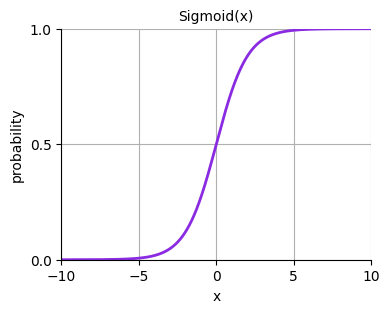

In [8]:
x_min, x_max = -10, 10
# x_min, x_max = -1,1
# x_min, x_max = -1000,1000

x = np.arange(x_min,x_max,0.01)

fig, axs = plt.subplots(1,1,figsize=(FIG_WIDTH,FIG_HEIGHT))
axs.plot(x,sigmoid(x),color=PURPLE)
plt.title('Sigmoid(x)')
axs.set_xlabel('x')
axs.set_ylabel('probability')
axs.set_xlim(x_min,x_max)
axs.set_ylim(0,1)
axs.set_yticks([0,0.5,1])
axs.grid()
plt.show()

The sigmoid function shown above outputs a probability value between $0$ and $1$ given a real value as an input. In the scope of binary logistic regression, our input is some data sample $x\in\mathcal{X}$, which has a corresponding true label $y$. We can think of the overall classifier as such:
$$
\begin{align} 
h_{\theta}(x) &= P(y=1|x,\theta),\\
1-h_{\theta}(x) &= P(y=0|x,\theta),\\
\end{align}
$$
where we predict that our data sample $x$ is in class $y=1$ if $h_{\theta}(x)\geq 0.5$.

How would we train such a classifier, or better yet, how do we choose $\theta$ so that our classifier is as best as it can be? If we knew how $x$ was distributed based on the label, we can solve this problem exactly using Bayes rule and what we  have learned about the Maximum Likelihood Estimate. But in this case, we are not given any information on how $x$ is distributed, and hence must learn the right $\theta$ some other way. To do this, we must first build a metric that desides how good a given choice of $\theta$ is at classifying our data. A general metric is shown below:

$$
J(\theta) = \frac{1}{N}\sum_{i=1}^{N}cost(h_{\theta}(x_i),y_i)
$$

So given a datset $\mathcal{X}$, we can sum over the individual data points $x_i$, checking how close our predicted label $h_{\theta}(x_i)$ is to the true target $y_i$ for each data point. You can see that this depends on not only the chosen value of $\theta$, but also the dataset $\mathcal{X}$. What should the cost be in this expression? Since we are working with probability values we use the log likelihood loss function, where:
$$
cost(h_{\theta}(x),y)= \begin{cases} -log(h_{\theta}(x)) \ &\text{if} \ y=1 \\ -log(1-h_{\theta}(x)) \ &\text{if} \ y=0  \end{cases}
$$


The intuition here is that the log function discounts greatly if we are far away from the true label, and less so when we are close. But this is not so convenient for us, as we do not want to deal with this conditional switching in our overall loss function $J(\theta)$. Luckily, a simpler cost function can be defined, that still has the same value as the expression above:
$$
cost(h_{\theta}(x),y)= -y log(h_{\theta}(x)) - (1-y)log(1-h_{\theta}(x))
$$

Your first task is to construct the defined loss function, $J(\theta)$, in the cell below. Remember that $J$ acts on a given dataset $\mathcal{X}$. Sometimes it is easier to think of our dataset as an $N$ by $d$ matrix, since this is how we work with it in python/numpy. 

$$
X=
\begin{bmatrix}
x_0\\
x_1\\
\vdots\\
x_N
\end{bmatrix}
$$

Remember that $N$ is the size of the dataset, and $d$ is the dimension of each data sample $x$. Since MNIST is a dataset of images, we want to flatten the image vectors before passing them along to our loss function. 

In [9]:
def compute_loss(x, y, theta):
    '''
    Computes the Negative Log-Likelihood cost
    Inputs:
        x     - np.array of MNIST digits size (N,28,28) or (28,28)
        y     - np.array of labels 0 for 'six' and 1 for 'nine'
        theta - np.array of the parameter vector we want to learn

    Tip: to avoid log(0), we add a small scalar value 
    '''
    h = sigmoid(np.dot(x.reshape(-1,28*28),theta))
    m = len(h)
    epsilon = 1e-11
    cost = (1/m)*np.sum((-(y*np.log(h+epsilon))-((1-y)*np.log(1-h+epsilon))))
    return cost

After building the above function, lets check that it works both on individual data samples from our MNIST dataset, and for subsets of the dataset. 

In [10]:
rng = np.random.default_rng(seed=123)
theta = rng.random(28*28)
x = data['x_train'][0]
y = data['y_train'][0]
print(compute_loss(x,y,theta))

25.328436022934504


In [11]:
x = data['x_train']
y = data['y_train']
print(compute_loss(x,y,theta))

12.60296625853482


Given our fancy loss function $J(\theta)$, how do we now use it to choose $\theta^*$, the best $\theta$. We want a $\theta^*$ that minimizes our loss function when evaluated over the entire dataset, which in our case is the training set provided. 

$$
\theta^* = \arg\min_{\theta} J(\theta)
$$

Okay so lets just use what we know from calculus, we take the derivative of $J$ with respsect to $\theta$, set that to zero and then... oh wait. If you go about this route, you will see that unless we had a closed form differentiable expression for $P(y|x)$, we can not solve the problem this way. Instead we rely on a famous numerical technique known as Gradient Descent (GD). 

GD assumes the given function is convex (you can think of that as meaning it only has one global minimum), and goes about finding the minimum value of the function. Essentially you can think of it as taking steps in the direction of the negative derivative (downhill), until it reaches the bottom of our function. So at every iteration of GD, we can update our current estimate of the paramater $\theta$, by taking a step in the direction of the negative derivate (gradient) of $J(\theta)$:

$$
\theta : \theta -\alpha \frac{\delta J}{\delta\theta}J(\theta),
$$

where $\alpha$ is the size of the steps we take. Intuitively, GD asks "which elements of $\theta$ can I tune so that our loss evaluated over the entire dataset decreases?". A larger gradient in those elements of $\theta$ corresponds to the loss being more sensetive in those dimensions. As we continue to iterate and update $\theta$ in this fashion, we are gauarnteed to reach the global minimum given that our function $J$ is convex. Even though our function may be highly non-convex, this approach is computationally efficient, and hence is used widely even in more complex settings such as Neural Networks, where there are no such gaurantees. 

For logistic regression, the gradient of $J$ is computed for you and shown below. For linear regression in the next part, it will be your job. 

$$
\begin{align}
\frac{\delta J}{\delta \theta} &= \frac{\delta}{\delta \theta}\Big(\frac{1}{N}\sum_{i=1}^{N}cost(h_{\theta}(x_i),y_i)\Big),\\
&= \frac{1}{N}\sum_{i=1}^{N}\frac{\delta}{\delta \theta}cost(h_{\theta}(x_i),y_i),\\
\end{align}
$$

where

$$
\begin{align}
\frac{\delta \ cost(h_{\theta}(x_i),y_i)}{\delta \theta} &= \frac{\delta}{\delta \theta}\Big(-y log(h_{\theta}(x)) - (1-y)log(1-h_{\theta}(x))\Big).\\
\end{align}
$$

Given that $\frac{\delta}{\delta x}\sigma(x) = \sigma(x)(1-\sigma(x))$ one can show:

$$
\begin{align}
\frac{\delta J}{\delta \theta[j]} &= \frac{1}{N}\sum_{i=1}^{N}\big((h_{\theta}(x_i)-y_i)x_i[j]\big)
\end{align}
$$

Note the indexing over the elements of $\theta$ which is needed when computing the gradient vector. The $j$ here denotes the dimension of $\theta$ at which we are evaluating this partial derivative, and hence we use the $j$'th element of datasamples $x_i$ to weight our derivative. 

### Question 1: Implementing Logistic Regression - Gradient Descent

Your task is to implement a Gradient Descent algorithm that utilizes this gradient to make updates to a given $\theta$ for some pre-defined number of iterations. The I/O of the function "GD" below is provided for you, your task it to complete it. Note that the following cells will evaluate the algorithm, so it will be clear if your code is correct.

In [12]:
def GD(x, y, theta, lr, num_iters):
    '''
    Computes gradient descent to minimize the MSE
    Inputs:
        x         - np.array of MNIST images
        y         - np.array representing the true labels
        theta     - np.array of the parameter vector we want to learn (initial guess)
        lr        - learning rate or step size 
        num_iters - number of steps we take
    
    Outputs:
        theta     - np.array of the parameter vector (after GD)
        loss      - np.array of the loss during each iteration of GD
    '''
    # you also want to store the computed loss as we iterate
    loss = np.zeros(num_iters)

    return loss, theta

### Evaluating Logistic Regression

Given our learned value of $\theta^*$, we want to make some predictions on the unseen data in our test dataset. This is commonly used as a metric for classification problems, since testing on the same dataset you train on can give biased results. 

In [13]:
def predict(x, theta):
    return np.round(sigmoid(np.dot(x.reshape(-1,28*28),theta)))

Here we can test your gradient descent implementation. Is your loss improving (decreasing) as you iterate? 

Initial Cost is: 11.808


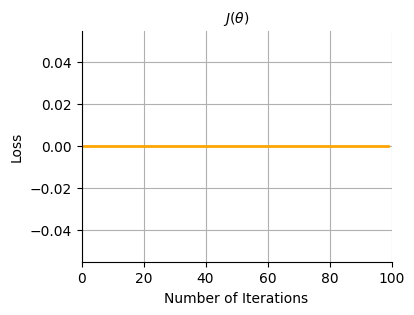

In [14]:
x = data['x_train']
y = data['y_train']

num_iters = 100
lr = 0.1
theta = rng.random(28*28)
print("Initial Cost is: %.3f"%compute_loss(x, y, theta))

loss, theta_star = GD(x, y, theta, lr, num_iters)

fig, axs = plt.subplots(1,1,figsize=(FIG_WIDTH,FIG_HEIGHT))
axs.plot(range(len(loss)), loss, 'ORANGE')
plt.title("$J(\\theta)$")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.grid()
plt.xlim(0,num_iters)
plt.show()



If the above plot of our loss fucntion looks like it has converged, we can see how our accuracy is on the test dataset. The solution should result in an accuracy of above 95%. We can also look at the some of the misclassified images to get a sense of what caused the classification errors. 

Accuracy on test set: 40.300


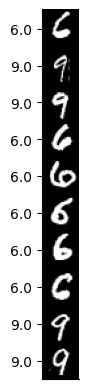

In [15]:
x = data['x_test']
y = data['y_test']

y_predict = predict(x, theta_star)
print("Accuracy on test set: %.3f"%(np.mean(y_predict==y)*100))
imshow_mnist(x[y_predict!=y][0:10],get_label(y[y_predict!=y][0:10]))

## III. Linear Regression - Predicting Housing Prices

Now that we have looked at logistic regression, you will implement a linear regression framework. A lot of the theory is the same here, but the main difference is in the cost function used to evaluate how close the predicted values are to the true ones. Remember that in linear regression, we are trying to estimate a continuous value, and hence we do not need to use a sigmoid in order to map our values to probabilities. Instead, we rely on the Mean Squared Error as our metric of cost, and sum this error over the whole dataset given a $\theta$.

$$
J(\theta) = \frac{1}{2N}\sum_{i=1}^{N}(\theta^\intercal x_i -y_i)^2,
$$

where the inner summation is the Mean Squared Error between the true value $y_i$, and our prediction $\theta^\intercal x_i$. 

Just like in the previous task, your job is to construct a linear regression framework using gradient descent by computing the gradient of the above loss function. You will be more or less on your own here, but a lot of the template has been provided as it is the same.

### Question 2: Data Processing - Housing
The dataset we will work with is the USA housing dataset. Each row in the csv is a sample from the dataset, where the 'features' are the columns of $X$. The column labels are now provided, which should be the header used in your pandas dataframe: 

```
Price,A. Income,A. House Age,A. Num Rooms,A. Num Bedrooms,A. Population
```

Your job is to learn some linear mapping $\theta^\intercal x$, that can estimate house prices (**column "Price" should not be used**). This is the standard linear regression setting. 

Your first task is to preprocess the data as before.

Note that the features vary greatly in their distribution, since they are not just pixel values. The number of bedrooms is a good dictator of home price, but its magnitude is small compared to the average income in the neighberhood. Because of this, you want to normalize the individual features, so that they have the same weight. Also, since we want to account for a bias term (think of zero-intercept in 2-dimensions,) we can do this directly by injecting $1$ as the first feature of every data point $x$. Finally, since the Price is what we are trying to model, we do not need to normalize it. However, I suggest using units of $1M dollars for better clarity. 

In [16]:
cwd = os.getcwd()
# display your current working directory
print(cwd)
# read in the mnist dataset
housing_path = cwd + '/data/housing.csv'
df = pd.read_csv(housing_path)
df.head()

/home/mark/Documents/code/ml_tutorial/content/lab2


,Price,A. Income,A. House Age,A. Num Rooms,A. Num Bedrooms,A. Population
0,1059033.5,79545.460,5.682861,7.009188,4.09,23086.800
1,1505890.9,79248.640,6.002900,6.730821,3.09,40173.070
2,1058988.0,61287.066,5.865890,8.512728,5.13,36882.160
3,1260616.8,63345.240,7.188236,5.586729,3.26,34310.242
4,630943.5,59982.195,5.040554,7.839388,4.23,26354.110


### Question 3: Implementing Linear Regression - Derivation + Loss + Gradient Descent + Evaluation 
Once you have done your data processing, you should implement the Linear Regression algorithm by performing gradient descent on the loss described above. The process is near identical to the previous logistic regression part, as you should see after deriving the gradient. 

**Note 1**: You are also required to evaluate your model. Boilerplate code for plotting is provided, as well as some useful metrics that you need to compute. 

**Note 2**: As a bonus (optional), try to answer: "Is GD required here? Can you derive a closed form solution? How does it compare to GD? (hint: they will be identical for this setting)"

In [17]:
# your GD implementatio goes here (feel free to use more cells)

### Evaluating Linear Regression

Lets see how your algorithm preforms.

Initial Cost is:


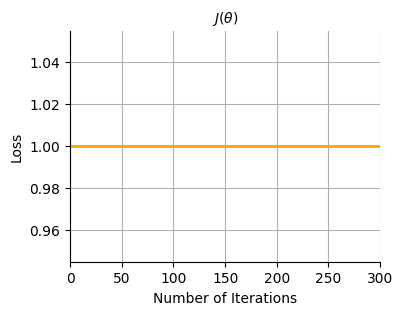

In [18]:
num_iters = 300
lr = 0.5
theta = rng.random(6)
print("Initial Cost is:")

fig, axs = plt.subplots(1,1,figsize=(FIG_WIDTH,FIG_HEIGHT))
axs.plot(range(num_iters), np.ones(num_iters), 'ORANGE')
axs.set_xlim(0,num_iters)
axs.grid()
plt.title("$J(\\theta)$")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()



As a final check, we can get a gauge of the quality of our predictions. Some useful metrics are:

1) Mean Squared Error (MSE) - Averages the squared differences between predictions and true values.
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n \bigl(y_i - \hat{y}_i\bigr)^2
$$

2) Root Mean Squared Error (RMSE) - The square root of MSE; converts the squared error to the same units.
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \bigl(y_i - \hat{y}_i\bigr)^2}
$$

3) Mean Absolute Error (MAE) - Averages the absolute differences between predictions and true values.
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n \bigl|\,y_i - \hat{y}_i\bigr|
$$

4) Coefficient of Determination (R^2) - Shows how much of the total variation is explained by our model.
$$
R^2 = 1 \;-\; \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2},
\quad \text{where} \quad
\bar{y} = \frac{1}{n}\sum_{i=1}^n y_i.
$$

In [19]:
# compute the 4 metric above